In [1]:
import torch 
import pickle
from tqdm import tqdm
from transformers import BertTokenizer,BertModel
from datasets import load_dataset
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
from transformers import BertTokenizer,BertModel
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

/home/prtissot/Documents/IA/ENV/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
# model = BertModel.from_pretrained("bert-base-uncased")

In [3]:
df = pd.read_csv('data/Yelp_cities/Atlanta_reviews.csv')
# with open("data_reviews/Atlanta_trainValidTest/labels.pickle", "rb") as f:
#     x = pickle.load(f)
# df_count = df.groupby('business_id').count()
# df_count = df_count[df_count.index.isin(x)]
# df = df[df.business_id.isin(df_count.index)]

/tmp/ipykernel_14627/966736329.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Yelp_cities/Atlanta_reviews.csv')


In [4]:
def get_sup(df, nb=100):
    df_count = df.groupby('business_id').count()
    df_plus = df_count[df_count.review_id >= nb]
    return df[df.business_id.isin(df_plus.index)]

def get_groupby_business(df):
    return df.groupby('business_id').count()

def get_groupby_price(df):
    return df.groupby('price').count()

In [5]:
df = get_sup(df,2)
df.price = df.price.astype(float).fillna(0.0)
get_groupby_price(df)

,business_id,review_id,user id,stars,review_date,text,name,categories,address,postal code,text_length
price,,,,,,,,,,,
0.0,93758,93758,93758,93758,93758,93758,13,13,13,13,13
1.0,99670,99670,99670,99670,99670,99670,99670,99670,99670,99670,99670
2.0,437486,437486,437486,437486,437486,437486,437486,437486,437486,437486,437486
3.0,44621,44621,44621,44621,44621,44621,44621,44621,44621,44621,44621
4.0,5754,5754,5754,5754,5754,5754,5754,5754,5754,5754,5754


In [6]:
df['review_date'] = pd.to_datetime(df['review_date'])  
df = df.loc[(df['review_date'] >= '2008-01-01') & (df['review_date'] <= '2020-01-01')]
print(df.shape)
get_groupby_price(df)

(540160, 12)


,business_id,review_id,user id,stars,review_date,text,name,categories,address,postal code,text_length
price,,,,,,,,,,,
0.0,13,13,13,13,13,13,13,13,13,13,13
1.0,91799,91799,91799,91799,91799,91799,91799,91799,91799,91799,91799
2.0,401769,401769,401769,401769,401769,401769,401769,401769,401769,401769,401769
3.0,41307,41307,41307,41307,41307,41307,41307,41307,41307,41307,41307
4.0,5272,5272,5272,5272,5272,5272,5272,5272,5272,5272,5272


In [7]:
get_groupby_business(df)

,review_id,user id,stars,review_date,text,name,categories,address,postal code,price,text_length
business_id,,,,,,,,,,,
-0JXXCMUpe29dQ-f6pG9OA,22,22,22,22,22,22,22,22,22,22,22
-0OWS89ebRdvzOQkjptyEw,31,31,31,31,31,31,31,31,31,31,31
-4P7VlKa9n-TwOP2_nWCtw,80,80,80,80,80,80,80,80,80,80,80
-5VyAi8GR34xmDAgFZTitg,425,425,425,425,425,425,425,425,425,425,425
-6VuqBXDDJXv8CRm_CM2qg,28,28,28,28,28,28,28,28,28,28,28
...,...,...,...,...,...,...,...,...,...,...,...
zy75CWA_oJYEhtXz8OOQsg,68,68,68,68,68,68,68,68,68,68,68
zyYNLYUVabUXkwq___Q3ug,27,27,27,27,27,27,27,27,27,27,27
zylYdVSB_KCGsB-Vunncsw,30,30,30,30,30,30,30,30,30,30,30


In [8]:
df = get_sup(df,100)
print(df.shape)

(462381, 12)


In [9]:
get_groupby_price(df)

,business_id,review_id,user id,stars,review_date,text,name,categories,address,postal code,text_length
price,,,,,,,,,,,
1.0,55375,55375,55375,55375,55375,55375,55375,55375,55375,55375,55375
2.0,364563,364563,364563,364563,364563,364563,364563,364563,364563,364563,364563
3.0,37669,37669,37669,37669,37669,37669,37669,37669,37669,37669,37669
4.0,4774,4774,4774,4774,4774,4774,4774,4774,4774,4774,4774


In [10]:
get_groupby_business(df)

,review_id,user id,stars,review_date,text,name,categories,address,postal code,price,text_length
business_id,,,,,,,,,,,
-5VyAi8GR34xmDAgFZTitg,425,425,425,425,425,425,425,425,425,425,425
-AIX1rem_OF-9Et3p_K9Gg,310,310,310,310,310,310,310,310,310,310,310
-CHazLwo2j2G8gWEZN53hA,755,755,755,755,755,755,755,755,755,755,755
-DISJqPp4zcDVw7R-MOjog,186,186,186,186,186,186,186,186,186,186,186
-EzfZm6rTohZdD9tfQaMyA,156,156,156,156,156,156,156,156,156,156,156
...,...,...,...,...,...,...,...,...,...,...,...
zpKvO2SOXHV9cxvBm6q4Fg,203,203,203,203,203,203,203,203,203,203,203
zpOcXfa6bbW6AG5L60UL_A,202,202,202,202,202,202,202,202,202,202,202
ztY4uPNUTWMN9LT3L5mD3Q,761,761,761,761,761,761,761,761,761,761,761


## Resampling

In [11]:
# df_p = df.groupby('business_id')
# df = df_p.apply(lambda x: x.sample(df_p.size().min(), replace=True, random_state=1).reset_index(drop=True)).reset_index(drop=True)

## Weight loss

In [12]:
nb_resto = get_groupby_business(df)['review_id'].tolist()

In [13]:
MAX_NB_RESTO = max(nb_resto)

In [14]:
ratio_resto = [MAX_NB_RESTO/p for p in nb_resto]
print(ratio_resto)
WEIGHT = torch.FloatTensor(ratio_resto).to(device)

[8.76, 12.009677419354839, 4.9311258278145695, 20.016129032258064, 23.865384615384617, 16.400881057268723, 8.093478260869565, 16.846153846153847, 6.894444444444445, 8.992753623188406, 18.25, 25.155405405405407, 15.384297520661157, 18.25, 16.32894736842105, 12.882352941176471, 10.516949152542374, 6.083333333333333, 9.169950738916256, 10.008064516129032, 32.94690265486726, 6.163907284768212, 6.589380530973451, 13.9438202247191, 22.293413173652695, 20.683333333333334, 32.6578947368421, 8.4421768707483, 16.77027027027027, 19.29015544041451, 29.547619047619047, 5.640909090909091, 14.155893536121672, 10.341666666666667, 22.427710843373493, 32.94690265486726, 7.989270386266094, 14.049056603773584, 20.915730337078653, 36.14563106796116, 22.427710843373493, 10.791304347826086, 21.033898305084747, 23.124223602484474, 3.9989258861439314, 10.982300884955752, 11.74447949526814, 6.818681318681318, 11.70754716981132, 12.620338983050848, 2.8638461538461537, 25.675862068965518, 3.155084745762712, 14.77

In [15]:
get_groupby_price(df)

,business_id,review_id,user id,stars,review_date,text,name,categories,address,postal code,text_length
price,,,,,,,,,,,
1.0,55375,55375,55375,55375,55375,55375,55375,55375,55375,55375,55375
2.0,364563,364563,364563,364563,364563,364563,364563,364563,364563,364563,364563
3.0,37669,37669,37669,37669,37669,37669,37669,37669,37669,37669,37669
4.0,4774,4774,4774,4774,4774,4774,4774,4774,4774,4774,4774


In [16]:
get_groupby_business(df)

,review_id,user id,stars,review_date,text,name,categories,address,postal code,price,text_length
business_id,,,,,,,,,,,
-5VyAi8GR34xmDAgFZTitg,425,425,425,425,425,425,425,425,425,425,425
-AIX1rem_OF-9Et3p_K9Gg,310,310,310,310,310,310,310,310,310,310,310
-CHazLwo2j2G8gWEZN53hA,755,755,755,755,755,755,755,755,755,755,755
-DISJqPp4zcDVw7R-MOjog,186,186,186,186,186,186,186,186,186,186,186
-EzfZm6rTohZdD9tfQaMyA,156,156,156,156,156,156,156,156,156,156,156
...,...,...,...,...,...,...,...,...,...,...,...
zpKvO2SOXHV9cxvBm6q4Fg,203,203,203,203,203,203,203,203,203,203,203
zpOcXfa6bbW6AG5L60UL_A,202,202,202,202,202,202,202,202,202,202,202
ztY4uPNUTWMN9LT3L5mD3Q,761,761,761,761,761,761,761,761,761,761,761


In [17]:
# df['weight'] = df.price.apply(lambda x: ratio_price[int(x)-1])

In [18]:
# df[['price', 'weight']].head(15)

In [19]:
# df['review_date'] = pd.to_datetime(df['review_date'])  
# df = df.loc[(df['review_date'] > '2008-01-01') & (df['review_date'] <= '2020-01-01')]

In [20]:
# display(df)
# print(df.columns)

In [21]:
# def get_sup(df, nb=100):
#     df_count = df.groupby('business_id').count()
#     df_plus = df_count[df_count.review_id >= nb]
#     return df[df.business_id.isin(df_plus.index)]

# df = get_sup(df,2)
# df = df.loc[(df['review_date'] > '2008-01-01') & (df['review_date'] <= '2020-01-01')]
# df = get_sup(df)

In [22]:
# df

In [23]:
labels = df['business_id']
print(len(labels))
LABELS = list(labels.unique())
# print(LABELS)
NB_CLASSES = len(LABELS)
print(NB_CLASSES)

462381
1404


In [24]:
# sent = df['text']
# sent = sent.unique()
# print(len(sent))
# sentToken = [tokenizer.tokenize(str(s)) for s in sent]
# NB_TOKEN = max(len(s) for s in sentToken)+2
# print(NB_TOKEN)

In [25]:
# sentTest = max(sentToken, key = len)
# print(sentTest)
# tok = tokenizer(sentTest, add_special_tokens=True, padding=True, return_tensors="pt")
# print(tok['input_ids'])
# print(tok['input_ids'].shape)

In [26]:
NB_TOKEN = 512

In [27]:
def split(df,ratio = 0.9):
    msk = np.random.rand(len(df)) < ratio
    train = df[msk]
    test = df[~msk]
    return train, test

In [28]:
train, test = split(df)
train, val = split(train)

In [29]:
print(len(train))
print(len(val))
print(len(test))

374784
41635
45962


In [30]:
class MyDataset(Dataset):
    def __init__(self, sentence, labels):
        self.wrapped_input = tokenizer(sentence, max_length=NB_TOKEN, add_special_tokens=True, truncation=True,
                          padding='max_length', return_tensors="pt")
        lab_idx = np.array([LABELS.index(l) for l in labels])
        self.labels = np.zeros((lab_idx.size, NB_CLASSES))
        self.labels[np.arange(lab_idx.size), lab_idx] = 1
        # self.labels = np.array(labels).astype(float)
    def __getitem__(self, idx):
        input_dict = {}
        for k in self.wrapped_input.keys():
            input_dict[k] = self.wrapped_input[k][idx]
        return input_dict, self.labels[idx]
    
    def __len__(self):
        return len(self.labels)

In [31]:
BATCH_SIZE = 100

trainset = MyDataset(train['text'].astype(str).tolist(), train['business_id'])
print('train done')
valset = MyDataset(val['text'].astype(str).tolist(), val['business_id'])

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

train done


In [36]:
# with open('train_dataloader.pkl', 'wb') as f:
#     pickle.dump(train_loader, f)
# with open('val_dataloader.pkl', 'wb') as f:
#     pickle.dump(val_loader, f)

In [37]:
# with open('train_dataloader.pkl', 'rb') as f:
#     train_loader = pickle.load(f)
# with open('val_dataloader.pkl', 'rb') as f:
#     val_loader = pickle.load(f)

In [38]:
# df['text'][:10].astype(str).tolist()

In [32]:
class BERT_classifier(nn.Module):
    def __init__(self, num_label):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        for param in self.bert.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_label),
        )

    def forward(self, wrapped_input):
        hidden = self.bert(**wrapped_input)
        last_hidden_state, pooler_output = hidden[0], hidden[1]
        logits = self.classifier(pooler_output)
        # logits = self.softmax(logits)

        return logits.squeeze()

    # def forward(self, input_ids, token_type_ids, attention_mask=None):
    #     pooled_out = self.bert(input_ids, token_type_ids, attention_mask)[1]
    #     logits = self.classifier(pooled_out)
    #     return logits

In [33]:
model = BERT_classifier(NB_CLASSES).to(device)
print(model)

BERT_classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [34]:
batch_data, batch_label = next(iter(train_loader))
for k, v in batch_data.items():
    batch_data[k] = v.to(device)
    print(v.shape)
batch_label = batch_label.to(device)

batch_logits = model(batch_data)
print(batch_logits.shape)
print(batch_logits)
print(batch_label)
print(batch_data['input_ids'].shape)
print(type(batch_label[0]))

torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1404])
tensor([[ 0.3269,  0.0519, -0.0199,  ...,  0.0365, -0.1256, -0.0881],
        [ 0.2087,  0.0575,  0.0316,  ..., -0.1215, -0.1483, -0.0575],
        [ 0.2793,  0.0428,  0.0041,  ..., -0.0106, -0.1181, -0.0916],
        ...,
        [ 0.2671,  0.0623, -0.0004,  ..., -0.0980, -0.1628, -0.0484],
        [ 0.2976,  0.0694, -0.0299,  ...,  0.0686, -0.1553, -0.0807],
        [ 0.2843,  0.1008, -0.0004,  ..., -0.0906, -0.1693, -0.0703]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
torch.Size([100, 512])
<class 'torch.Tensor'>


In [35]:
criterion = nn.CrossEntropyLoss(weight=WEIGHT)
# criterion = nn.CrossEntropyLoss()
loss = criterion(batch_logits, batch_label)
print(loss)

tensor(127.0077, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)


In [36]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss, correct = 0, 0
    for data, label in tqdm(train_loader):
        device_data = {}
        for k, v in data.items():
            device_data[k] = v.to(device)
        device_label = label.to(device)
        
        optimizer.zero_grad()
        output = model(device_data)
        loss = criterion(output, device_label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1)
        lab = device_label.argmax(dim=1)
        correct += pred.eq(lab).sum().item()

    train_loss /= len(train_loader)
    acc = correct/len(train_loader.dataset)

    return train_loss, acc


def val(model, val_loader, criterion, min_val_loss):
    model.eval()
    val_loss, correct = 0, 0.
    with torch.no_grad():
        for data, label in val_loader:
            device_data = {}
            for k, v in data.items():
                device_data[k] = v.to(device)
            device_label = label.to(device)
            
            output = model(device_data)
            val_loss += criterion(output, device_label).item()

            pred = output.argmax(dim=1)
            lab = device_label.argmax(dim=1)
            correct += pred.eq(lab).sum().item()
            
        val_loss /= len(val_loader)
        acc = correct/len(val_loader.dataset)
        
    if min_val_loss>val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'best-model-parameters.pt')
        print('model saved')

    return val_loss, acc, min_val_loss

def fit(model, train_loader, val_loader, epochs, optimizer, criterion):
    loss_train_per_epoch = []
    acc_train_per_epoch = []
    loss_val_per_epoch = []
    acc_val_per_epoch = []
    min_val_loss = 1000
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch+1)
        val_loss, val_acc, min_val_loss = val(model, val_loader, criterion, min_val_loss)

        print(f'[{epoch + 1}, {len(train_loader) + 1:5d}] loss: {train_loss:.3f}, accuracy: {train_acc:.3f} loss_val: {val_loss:.3f}, accuracy_val: {val_acc:.3f}')
        
        loss_train_per_epoch += [train_loss]
        acc_train_per_epoch += [train_acc]
        loss_val_per_epoch += [val_loss]
        acc_val_per_epoch += [val_acc]
        
    return loss_train_per_epoch, loss_val_per_epoch, acc_train_per_epoch, acc_val_per_epoch
    
    

In [37]:
optimizer = optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss(weight=WEIGHT)
# criterion = nn.CrossEntropyLoss()
epochs=30
loss_train_per_epoch, loss_val_per_epoch, acc_train_per_epoch, acc_val_per_epoch = fit(model, train_loader, val_loader, epochs, optimizer, criterion)

100%|█████████████████████████████████████| 3748/3748 [2:08:19<00:00,  2.05s/it]


model saved
[1,  3749] loss: 121.568, accuracy: 0.008 loss_val: 121.800, accuracy_val: 0.007


100%|█████████████████████████████████████| 3748/3748 [2:08:21<00:00,  2.05s/it]


model saved
[2,  3749] loss: 119.830, accuracy: 0.009 loss_val: 119.381, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:33<00:00,  2.06s/it]


model saved
[3,  3749] loss: 119.425, accuracy: 0.009 loss_val: 118.952, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:46<00:00,  2.06s/it]


[4,  3749] loss: 119.067, accuracy: 0.009 loss_val: 119.056, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:40<00:00,  2.06s/it]


model saved
[5,  3749] loss: 118.938, accuracy: 0.009 loss_val: 118.718, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:25<00:00,  2.06s/it]


model saved
[6,  3749] loss: 118.850, accuracy: 0.009 loss_val: 118.477, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:23<00:00,  2.06s/it]


model saved
[7,  3749] loss: 118.770, accuracy: 0.009 loss_val: 118.340, accuracy_val: 0.008


100%|█████████████████████████████████████| 3748/3748 [2:08:22<00:00,  2.06s/it]


[8,  3749] loss: 118.702, accuracy: 0.009 loss_val: 118.459, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:21<00:00,  2.05s/it]


[9,  3749] loss: 118.643, accuracy: 0.009 loss_val: 118.445, accuracy_val: 0.008


100%|█████████████████████████████████████| 3748/3748 [2:08:20<00:00,  2.05s/it]


model saved
[10,  3749] loss: 118.659, accuracy: 0.009 loss_val: 118.195, accuracy_val: 0.008


100%|█████████████████████████████████████| 3748/3748 [2:08:20<00:00,  2.05s/it]


[11,  3749] loss: 118.544, accuracy: 0.009 loss_val: 118.251, accuracy_val: 0.007


100%|█████████████████████████████████████| 3748/3748 [2:08:22<00:00,  2.06s/it]


model saved
[12,  3749] loss: 118.535, accuracy: 0.009 loss_val: 118.081, accuracy_val: 0.008


100%|█████████████████████████████████████| 3748/3748 [2:08:27<00:00,  2.06s/it]


[13,  3749] loss: 118.461, accuracy: 0.009 loss_val: 118.389, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:44<00:00,  2.06s/it]


model saved
[14,  3749] loss: 118.467, accuracy: 0.009 loss_val: 118.036, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:39<00:00,  2.06s/it]


[15,  3749] loss: 118.440, accuracy: 0.009 loss_val: 118.736, accuracy_val: 0.008


100%|█████████████████████████████████████| 3748/3748 [2:08:34<00:00,  2.06s/it]


model saved
[16,  3749] loss: 118.443, accuracy: 0.009 loss_val: 117.935, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:28<00:00,  2.06s/it]


model saved
[17,  3749] loss: 118.385, accuracy: 0.009 loss_val: 117.896, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:15<00:00,  2.05s/it]


[18,  3749] loss: 118.395, accuracy: 0.009 loss_val: 117.901, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:13<00:00,  2.05s/it]


[19,  3749] loss: 118.360, accuracy: 0.009 loss_val: 119.818, accuracy_val: 0.007


100%|█████████████████████████████████████| 3748/3748 [2:08:13<00:00,  2.05s/it]


[20,  3749] loss: 118.401, accuracy: 0.009 loss_val: 118.144, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:12<00:00,  2.05s/it]


model saved
[21,  3749] loss: 118.361, accuracy: 0.009 loss_val: 117.814, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:13<00:00,  2.05s/it]


[22,  3749] loss: 118.341, accuracy: 0.009 loss_val: 119.156, accuracy_val: 0.008


100%|█████████████████████████████████████| 3748/3748 [2:08:23<00:00,  2.06s/it]


model saved
[23,  3749] loss: 118.311, accuracy: 0.009 loss_val: 117.796, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:35<00:00,  2.06s/it]


[24,  3749] loss: 118.321, accuracy: 0.009 loss_val: 117.979, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:35<00:00,  2.06s/it]


[25,  3749] loss: 118.299, accuracy: 0.009 loss_val: 118.958, accuracy_val: 0.008


100%|█████████████████████████████████████| 3748/3748 [2:08:28<00:00,  2.06s/it]


[26,  3749] loss: 118.306, accuracy: 0.009 loss_val: 117.916, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:25<00:00,  2.06s/it]


[27,  3749] loss: 118.322, accuracy: 0.009 loss_val: 119.017, accuracy_val: 0.008


100%|█████████████████████████████████████| 3748/3748 [2:08:24<00:00,  2.06s/it]


[28,  3749] loss: 118.280, accuracy: 0.009 loss_val: 118.122, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:23<00:00,  2.06s/it]


model saved
[29,  3749] loss: 118.293, accuracy: 0.009 loss_val: 117.791, accuracy_val: 0.009


100%|█████████████████████████████████████| 3748/3748 [2:08:21<00:00,  2.05s/it]


[30,  3749] loss: 118.278, accuracy: 0.009 loss_val: 118.048, accuracy_val: 0.010


In [38]:
batch_data, batch_label = next(iter(val_loader))
for k, v in batch_data.items():
    batch_data[k] = v.to(device)
batch_logits = model(batch_data)
print(batch_logits)
print(batch_label)

tensor([[-1.8419, -2.2597, -2.1279,  ..., -4.7962, -4.9809, -3.2485],
        [-1.1398, -2.0111, -2.1409,  ..., -3.9262, -4.5331, -2.3656],
        [-1.2962, -2.0665, -2.1380,  ..., -4.1200, -4.6329, -2.5622],
        ...,
        [-0.5227, -1.7926, -2.1524,  ..., -3.1614, -4.1396, -1.5895],
        [ 0.5686, -1.4063, -2.1727,  ..., -1.8091, -3.4437, -0.2172],
        [-0.9674, -1.9501, -2.1441,  ..., -3.7125, -4.4232, -2.1488]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


In [39]:
def show_loss(loss_train,loss_val):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(loss_val,label="val")
    plt.plot(loss_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def show_acuracy(acc_train,acc_val):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(acc_val,label="val")
    plt.plot(acc_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [40]:
def show_matrix_confusion(model, val_dataloader):
    model.eval()
    val_acc = 0.0
    true_lab = []
    pred = []
    with torch.no_grad():
        for data, label in val_loader:
            device_data = {}
            for k, v in data.items():
                device_data[k] = v.to(device)
            device_label = label.to(device)
            
            output = model(device_data)
            out = output.argmax(dim=1)
            lab = device_label.argmax(dim=1)
            val_acc += out.eq(lab).sum().item()
            true_lab += [lab.cpu().numpy()]
            pred += [out.cpu().numpy()]
    
    print(f'accuracy: {val_acc / len(val_dataloader.dataset):.3f}')
    y_pred = np.concatenate(pred)
    y_true = np.concatenate(true_lab)

    print("Balanced accuracy :",balanced_accuracy_score(y_true, y_pred))
    
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
    
    cm_display.plot()
    plt.show() 

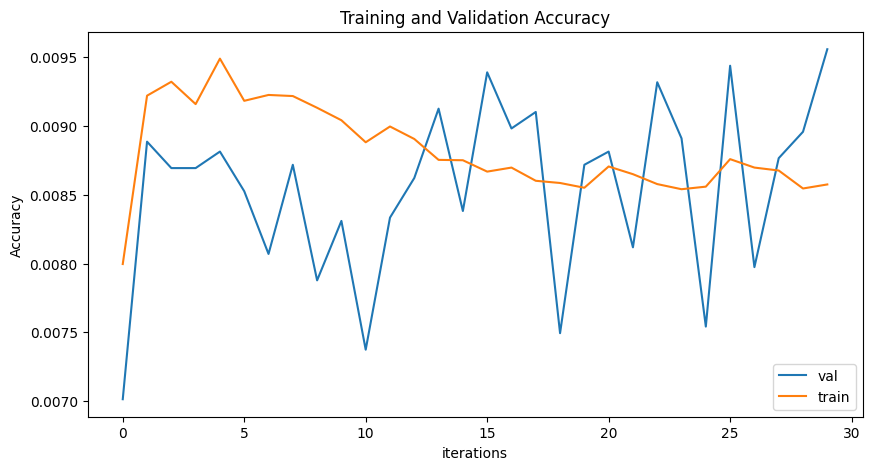

In [41]:
show_acuracy(acc_train_per_epoch,acc_val_per_epoch)

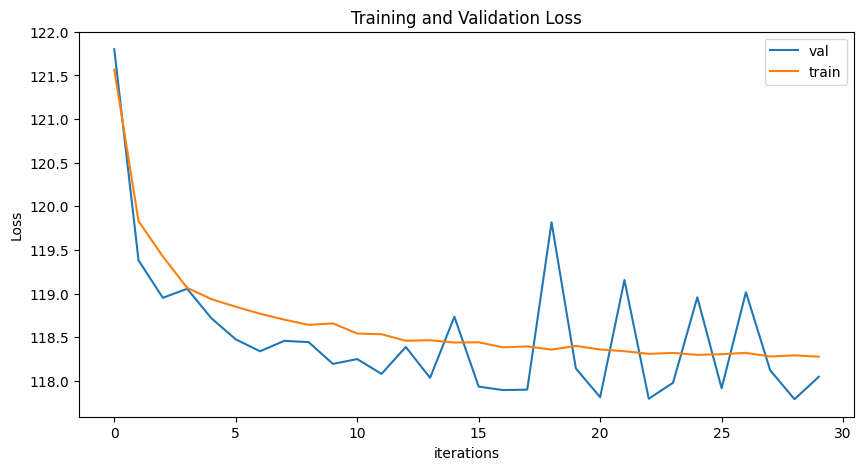

In [42]:
show_loss(loss_train_per_epoch,loss_val_per_epoch)

In [43]:
show_matrix_confusion(model, val_loader)

KeyboardInterrupt: 